<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#face-alignment" data-toc-modified-id="face-alignment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>face alignment</a></span></li><li><span><a href="#extract-apex-frame-and-neutral-frame" data-toc-modified-id="extract-apex-frame-and-neutral-frame-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>extract apex frame and neutral frame</a></span></li><li><span><a href="#Example:-select-apex-frame" data-toc-modified-id="Example:-select-apex-frame-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example: select apex frame</a></span></li></ul></div>

In [25]:
import sys, os, glob
import pandas as pd
import numpy as np  
import tqdm
from PIL import Image
from skimage import io, transform
import imageio
import matplotlib.pyplot as plt
import dlib         # 机器学习的库 Dlib
import warnings
warnings.filterwarnings('ignore')

## face alignment

In [26]:
def rotate(img, landmarks):
    left_eye, right_eye = np.mean(landmarks[36:41], axis=0), np.mean(landmarks[42:47], axis=0) #用于计算旋转角
    tmp = right_eye-left_eye
    rotate = np.arctan(tmp[1]/tmp[0])
    center = (left_eye+right_eye)/2 #旋转中心, 事实上无论以哪个点为旋转中心，旋转rotate角度均可摆正图像，确定
    #该点是为了计算旋转后的特征点坐标
    img_rotate = transform.rotate(img, angle=rotate*180/np.pi, center=center)
    landmarks_rotate = (landmarks-center).astype(np.float)
    rotate_matrix = np.array([[np.cos(rotate), - np.sin(rotate)], [np.sin(rotate), np.cos(rotate)]])
    landmarks_rotate = np.matmul(landmarks_rotate, rotate_matrix)
    landmarks_rotate = landmarks_rotate + center
    return img_rotate, landmarks_rotate
def crop(img, landmarks):
    left, right = int(landmarks[:,0].min()), int(landmarks[:,0].max())
    up, down = int(landmarks[:,1].min()), int(landmarks[:,1].max())
    width, height = right-left, down-up
    left, right = int(left-0.05*width), int(right+0.05*width)
    up, down = int(up-0.1*height), int(down+0.1*height)
    img_crop = img[up:down, left:right]
    landmarks_crop = landmarks-[left, up]
    return img_crop, landmarks_crop
def resize(img, landmarks, size=108):
    w, h, c = img.shape
    img = transform.resize(img, (size, size, 3))
    landmarks = landmarks/np.array([h, w])*size
    return img, landmarks
def normalize(img, landmarks):
    img, landmarks = rotate(img, landmarks)
    img, landmarks = crop(img, landmarks)
    img, landmarks = resize(img, landmarks, size=108)
    return img, landmarks
def showImgLandmarks(img, landmarks=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    ax.imshow(img)
    if landmarks is not None:
        ax.scatter(landmarks[:,0], landmarks[...,1])
        for i in range(landmarks.shape[0]):
            ax.text(landmarks[i,0], landmarks[i,1], i)
    plt.show()

## extract apex frame and neutral frame

In [27]:
class FrameExtract(object):
    def __init__(self, face_detector, landmark_detector, pos='cneter'):
        """
            face_detector: dlib.get_frontal_face_detector()
            landmark_detector: dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat'), 68 points
            pos: face location in video image : left part, right part or  different face orientations(like 
                 left, right, up, down)
        """
        self.face_detector = face_detector
        self.landmark_detector = landmark_detector
        self.pos = pos 
    def setData(self, data, video_id):
        """
            data: video
            video_id: video number
        """
        self.data = data
        self.video_id = video_id
    def __len__(self):
        """ return length of the video """
        return self.data.count_frames()
    def detectLandmarks(self, img):
        """
            img: PIL.Image
            return: img, landmarks(If detection fails，landmarks=None)
        """
        img_gray = np.array(img.convert('L'))
        faces = self.face_detector(img_gray, 0)
        if faces.__len__()>0: 
            landmarks = np.array([[p.x, p.y] for p in self.landmark_detector(np.array(img), faces[0]).parts()])
        else: landmarks = None
        return np.array(img), landmarks
    def getIthFrame(self, i):
        """
            step1: detect face
            step2: face alignment
            return: img and corresponding landmarks after face alignment
        """
        img = self.data.get_data(i)
        raw_img = Image.fromarray(img)
        w, h = raw_img.size
        if self.pos == "center":
            img, landmarks = self.detectLandmarks(raw_img)
        elif self.pos == "left": 
            img, landmarks = self.detectLandmarks(raw_img.crop(box=(0,0, w//2, h)))
        elif self.pos == "right":
            img, landmarks = self.detectLandmarks(raw_img.crop(box=(w//2,0, w, h)))
        elif self.pos == "90": # face oriented to right
            img, landmarks = self.detectLandmarks(raw_img.rotate(90)) # rotate anticlockwise 90
        elif self.pos == "180": # face oriented to down
            img, landmarks = self.detectLandmarks(raw_img.rotate(180))
        elif self.pos == "270": # face oriented to left
            img, landmarks = self.detectLandmarks(raw_img.rotate(270))
        if landmarks is None: return None, None #  landmark detection fail
        img, landmarks = normalize(img, landmarks)
        return img, landmarks
    def showImgLandmarks(self, img, landmarks=None, ax=None):
        """
            visualize i-th frame with landmarks
        """
        if ax is None:
            fig = plt.figure()
            ax = fig.add_subplot(1,1,1)
        ax.imshow(img)
        if landmarks is not None:
            ax.scatter(landmarks[:,0], landmarks[...,1])
            for i in range(landmarks.shape[0]):
                ax.text(landmarks[i,0], landmarks[i,1], i)
        plt.show()
    def getAmplitude(self):
        """
            consider the first frame as the neutral frame
            return the amplitude of movement of each frame compared with the first frame, if fails, return None
        """
        img, landmarks = self.getIthFrame(0)
        if img is None: return None
        nose_center = landmarks[30]
        mouth_center = (landmarks[48]+landmarks[54])/2
        left_eye_center = (landmarks[36]+landmarks[39])/2
        right_eye_center = (landmarks[42]+landmarks[45])/2

        nose_len_base = self.dist(nose_center, landmarks[27])+self.dist(nose_center, landmarks[31])+self.dist(nose_center, landmarks[35])
        mouth_len_base = self.dist(mouth_center, landmarks[48])+self.dist(mouth_center, landmarks[54])
        left_eye_len_base = self.dist(left_eye_center, landmarks[36])+self.dist(left_eye_center, landmarks[39])
        right_eye_len_base = self.dist(right_eye_center, landmarks[42])+self.dist(right_eye_center, landmarks[45])

        moves = []
        for i in range(self.__len__()): #tqdm.tqdm_notebook(range(self.__len__())):
            try:
                img, landmarks = self.getIthFrame(i)
            except:
                continue
            if img is None: return None #If a frame detection fails, the video is discarded. 
            # compute the amplitude of movement compared with the first frame
            move = 0
            nose_len = self.dist(nose_center, landmarks[27])+self.dist(nose_center, landmarks[31])+self.dist(nose_center, landmarks[35])
            mouth_len = self.dist(mouth_center, landmarks[48])+self.dist(mouth_center, landmarks[54])
            left_eye_len = self.dist(left_eye_center, landmarks[36])+self.dist(left_eye_center, landmarks[39])
            right_eye_len = self.dist(right_eye_center, landmarks[42])+self.dist(right_eye_center, landmarks[45])
            move += abs(nose_len-nose_len_base)/nose_len_base+abs(mouth_len-mouth_len_base)/mouth_len_base
            move += abs(left_eye_len-left_eye_len_base)/left_eye_len_base+abs(right_eye_len-right_eye_len_base)/right_eye_len_base
            moves.append(move/4)
        moves = np.array(moves)
        return moves
    def smoothAmplitude(self, moves):
        # smooth the curve of amplitude
        avg_moves = np.zeros_like(moves) # 每个值为附近20%个值的平均
        interval = len(moves)//20
        for i in range(len(moves)):
            s = max(0, i-interval);
            e = min(len(moves), i+interval)
            avg_moves[i] = np.array(moves[s:e]).mean()
        return avg_moves
    def showAmplitude(self, moves, avg_moves):
        # visualize the amplitude curve
        fig = plt.figure(figsize=(8,3))
        ax = fig.add_subplot(1,2,1)
        ax.plot(range(len(moves)), moves)
        ax.set_xlabel('frame no')
        ax.set_ylabel('offset')
        ax.set_title('before smooth')
        
        ax = fig.add_subplot(1,2,2)
        ax.plot(range(len(moves)), avg_moves)
        ax.plot(range(len(moves)), np.ones_like(avg_moves)*np.mean(avg_moves))
        ax.set_xlabel('frame no')
        ax.set_ylabel('offset')
        ax.set_title('after smooth')
        plt.tight_layout()
        plt.show()
    def showSelectedImg(self, lists):
        fig = plt.figure(figsize=(3*2,2*2))
        for i, val in enumerate(lists):
            ax = fig.add_subplot(2,3,i+1)
            img, _ = self.getIthFrame(val)
            ax.imshow(img)
            ax.set_title(str(val))
        plt.tight_layout()
        plt.show()
    def saveImages(self, lists, path, neutral=False):
        """
            lists: apex frames' ID
            path: save path
            netural: whether to save the neutral frame, if True, save the first frame the video as the netural frame
            save the frames indicated by lists as the apex frame
        """
        if not os.path.exists(path):
            os.makedirs(path)
        if neutral is True:
            img, landmarks = self.getIthFrame(0)
            img_path = path+"/neutral.jpeg"
            io.imsave(arr=img, fname=img_path)
            np.save(arr=landmarks, file=img_path[:-4])
        for val in lists:
            img, landmarks = self.getIthFrame(val)
            img_path = path+"/apex_%04d.jpeg" % val
            io.imsave(arr=img, fname=img_path)
            np.save(arr=landmarks, file=img_path[:-4])
    def dist(self, x, y):
        # compute teh euclidian distance between two landmarks
        return np.sqrt(np.power(x-y,2).sum())

## Example: select apex frame 

In [28]:
face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
extractor = FrameExtract(face_detector, landmark_detector)

In [29]:
video_path = './videos/mmi-facial-expression-database_download_2019-05-13_03_06_41/Sessions/2/S001-002.avi'
video_ID = 1
save_path = './onset_apex_pairs/0002'

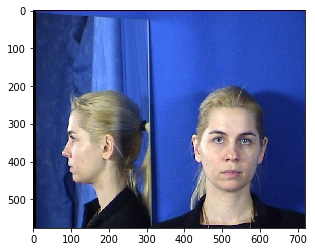

In [30]:
vid = imageio.get_reader(video_path, 'ffmpeg')
plt.imshow(vid.get_data(0)) # 图像的位置在右边

In [31]:
extractor.pos = "right"
extractor.setData(vid, video_ID)

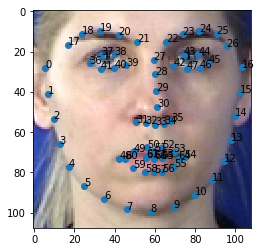

In [32]:
extractor.showImgLandmarks(*extractor.getIthFrame(0))

In [33]:
amplitudes = extractor.getAmplitude()
avg_amplitudes = extractor.smoothAmplitude(amplitudes)

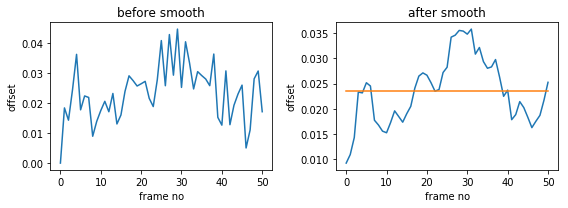

In [34]:
extractor.showAmplitude(moves=amplitudes, avg_moves=avg_amplitudes)

In [35]:
s, e = int(len(amplitudes)*0.1), int(len(amplitudes)*0.9)
amplitudes, avg_amplitudes = amplitudes[s:e], avg_amplitudes[s:e]
selectFrames = np.argsort(avg_amplitudes)
if selectFrames.__len__()>10: selectFrames = selectFrames[-5:]
else: selectFrames = selectFrames[-5:]

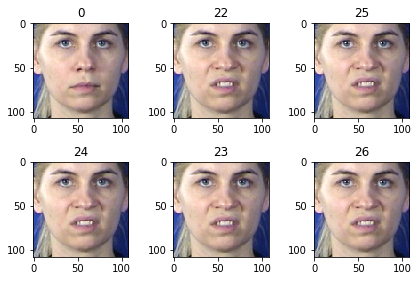

In [36]:
extractor.showSelectedImg(lists=[0, *selectFrames])